##Introduction

Today, you'll learn useful techniques for working with data in the frequency domain rather than the time domain. We'll focus on filtering 1D signals in a variety of ways. There are some common problems that we'll discuss, along with ways to avoid them.

**Fourier transform refresher from Part II**

Let's remind ourselves about a few critical details about Fourier transforms and working with frequency space representations of signals.



1.   Any signal can be represented as a sum of sin/cos components with different frequencies
<p align="center">
  <img width="500" src="https://i.stack.imgur.com/k5uDM.png">
</p>
<p align="center">
  <img width="700" src="https://www.compadre.org/osp/EJSS/4487/T09_Fourier/sinesadd4.jpg">
</p>
2.   We will be working with measurements that are real-valued, not complex. This means that when we take the Fourier transform, the positive frequency content has the same information as the negative frequency content.
<p align="center">
  <img width="500" src="https://upload.wikimedia.org/wikipedia/commons/4/40/Fourier_transform_of_oscillating_function.svg">
</p>
3.   In frequency space, the Fourier transform of a real-valued signal is complex. Each frequency has two important pieces of information - amplitude and phase. Most of the time we are going to be interested in the amplitude, so we'll want to use a function like np.abs() to get the amplitude of the complex value.
<p align="center">
  <img width="300" src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Complex_number_illustration_modarg.svg">
</p>
4.   We'll be using a few functions from the SciPy module scipy.fft, which has an extensive set of discrete Fourier transform functions. Primarily, we'll be working with scipy.fft.fft and scipy.fft.ifft, which are the 1-D Fourier and inverse Fourier transforms. We'll also be using a helper function scipy.fft.fftfreq which makes it easier for us to use our time array from the input data to calculate a frequency array.
5.   Remember that the NumPy and SciPy fft modules use a convention for ordering frequencies that may seem weird. The first half of the frequencies are the positive frequencies, and the second half are the negative frequencies:

     `step_size * [0, 1, 2, ... , len(time)/2 - 1, -len(time)/2, ..., -1]`

     if the length of the time array is even


##Let's get started filtering!

This is a common technique in a lot of signal processing. A filter is used to select certain frequency components in your signal to either pass or block. Common filters include:
1.   Low-pass: accept low frequencies and reject high frequencies
2.   High-pass: accept high frequencies and reject low frequencies
3.   Band-pass: accept frequencies only within a certain range
4.   Band-stop: reject frequencies only within a certain range

Low-pass and high-pass filters can be combined to form the band-pass and band-stop filters.

Let's start with making a filter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**Simple low-pass filter:**

The simplest filter is called a rectangle, box, or top-hat because of how it looks in frequency space: the value of the filter is one for the frequencies you want to keep, and zero for everything else. Our first example will construct one of these filters. Let's assume the raw data is sampled at a rate of 1 MHz and we want to keep frequency content below 50 kHz.

The filter array is like masking. We are going to multiply the frequency representation of our signal by the filter that we construct.

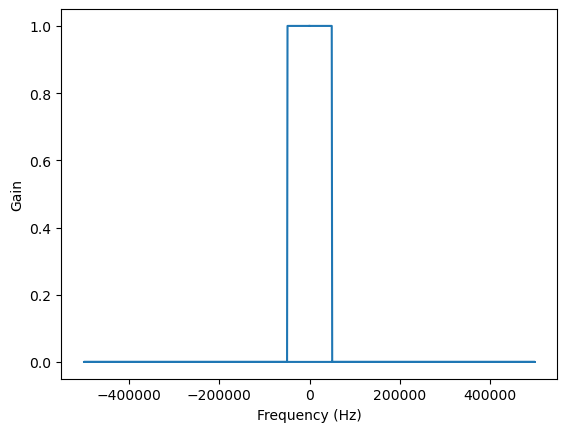

In [2]:
# sample code to make a top-hat filter
from scipy.fft import fftfreq

dt = 1e-6 # step size is us
nsamples = 1000

# define the array of frequencies we will use
frequencies = fftfreq(nsamples, dt)

# create the array to store the filter in
filter_lowpass = np.zeros(len(frequencies))

# identify index values for frequencies we want to pass through the filter
indices = np.where(np.abs(frequencies) < 5e4)

# set filter value to 1 for frequencies we want to pass
filter_lowpass[indices] = 1

# Plot filter in frequency space
plt.plot(frequencies, filter_lowpass)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.show()

Notice that the frequencies only go up to 500 kHz, even though the sample rate is 1 MHz. This is known as the Nyquist limit for the data. If you had a 1 MHz sine wave, but you only sampled it at 1 MHz, then every time you took a measurement the sine wave would have the same value. In this case, it would look just like a constant value rather than a sine wave, so you wouldn't be able to resolve it. It turns out that you can only properly resolve frequencies that are less than half of the sample rate. A phenomemon known as aliasing affects frequencies above this limit - because they aren't sampled fast enough, the frequencies are "aliased" to lower frequencies.

We can examine how this filter affects signals in the time domain by taking the inverse Fourier transform to get something called the impulse response function. This is the output signal we would get if we took a delta function impulse as our input signal and passed it through the filter.

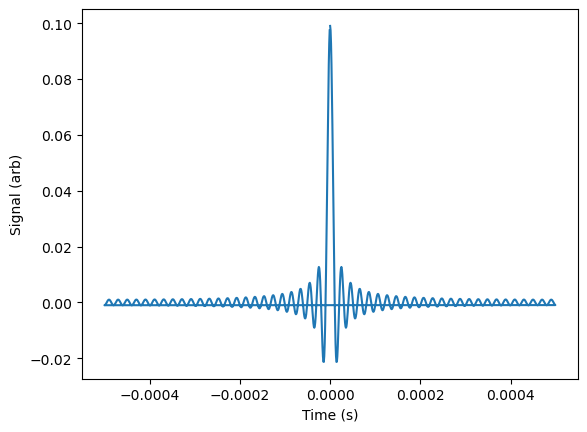

In [3]:
from scipy.fft import fft, ifft

# define the time array based on step size from previous example
time = np.arange(nsamples)*dt

# calculate the impulse response for the low pass filter defined above
impulse = ifft(filter_lowpass).real

time[int(nsamples/2):] -= .001 # Fourier transform is periodic, so just shift half of signal here

# Plot impulse response
plt.plot(time, impulse)
plt.xlabel('Time (s)')
plt.ylabel('Signal (arb)')
plt.show()

It turns out that the Fourier transform of a rectangle function is the sinc function:

$\frac{\sin(x)}{x}$

Our filter function looked ideal in frequency space! We were selecting only the frequency components we wanted, but it turns out that this filter produces a signal that is spread out in time and has a lot of "ringing" - those oscillations. This isn't desirable for most applications, so we want to try designing a better filter.

**Exercise 1**

Let's see if we can make our simple filter a little better. For all frequencies less than 50 kHz, leave the filter set to one - these frequencies are passed without any attenuation. Above 50 kHz, though, the filter won't drop to zero immediately. Try an exponential drop off for all frequencies above 50 kHz, and experiment with the width of the drop off. Then look at the impulse function with the inverse Fourier transform.

Solution:

In [4]:
# Try it out here! Make your own modifications to the filter we had before

# create the array to store the filter in
filter_exponential = np.zeros(len(frequencies))

# identify frequencies we want to pass from before
indices = np.where( np.abs(frequencies) < 5e4)[0]
filter_exponential[indices] = 1

# identify frequencies outside of pass region and calculate exponential decay
indices = np.where( np.abs(frequencies) >= 5e4)[0]
filter_exponential[indices] = np.exp( -(np.abs(frequencies[indices]) - 5e4) / (2e4))
# Be careful to make sure this works for both positive/negative frequencies

# calculate the impulse response for our new filter
impulse_exp = ifft(filter_exponential).real

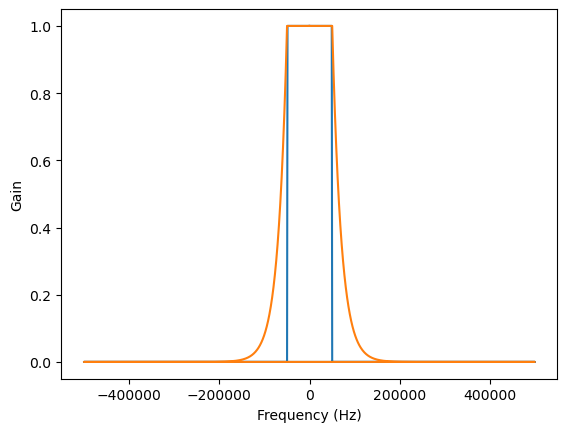

In [5]:
# Plot filter in frequency space
plt.plot(frequencies, filter_lowpass)
plt.plot(frequencies, filter_exponential)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.show()

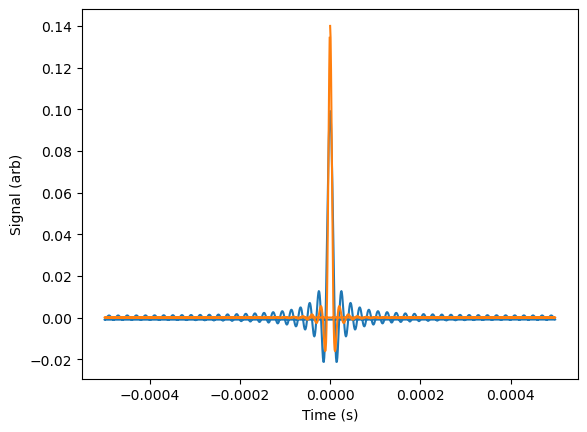

In [6]:
# plot the new and old impulse response functions together
plt.plot(time, impulse)
plt.plot(time, impulse_exp)
plt.xlabel('Time (s)')
plt.ylabel('Signal (arb)')
plt.show()

So our adjustment allowed more power from higher frequency components past the filter, but significantly improved the response in the time domain.

We could clearly spend a lot more time trying to optimize the filter shape, though. Fortunately, filter design is something that a lot of other people have already put plenty of effort into. The scipy.signal module has plenty of filter functions already made for us.

##Bandpass filtering with scipy.signal

Let's try out one of these other filters! A commonly used filter is the Butterworth filter, which is implemented with scipy.signal.butter. In order to use this filter, we need to define a few things:

1.   Order - basically this is how many terms the polynomial expansion has
2.   Critical frequency (or frequencies) - the cutoff frequency(ies) of the filter
3.   Filter type - a string indicating 'lowpass', 'highpass', etc.
4.   Output type - there are a variety of output types available, but we'll stick with something called 'second order sections' representation for our filter. Scipy recommends this for numerical stability reasons.

We'll also look at the frequency response of the filter with scipy.signal.sosfreqz. The sosfreqz function needs the output from signal.butter in 'sos' form, and we'll also pass the number of samples we want to test it on and the sample frequency.

We'll create a bandpass filter this time, and we'll design it to pass frequencies between 50 kHz and 100 kHz.

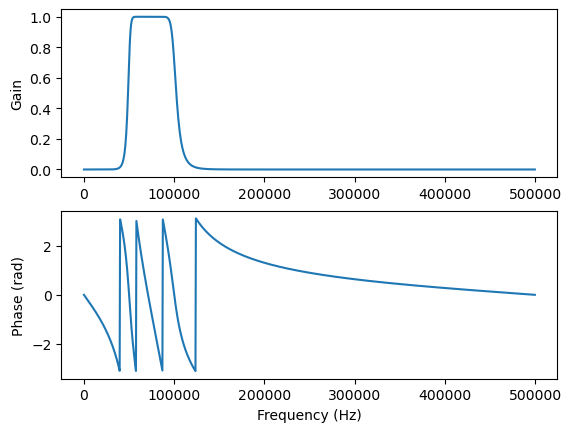

In [7]:
from scipy import signal

# define the parameters we need to pass to the Butterworth filter function
order = 8
cutoff_frequencies = [5e4, 1e5]
sample_frequency = 1/dt

# create the filter
filter_sos = signal.butter(order, cutoff_frequencies, btype='bandpass', output='sos', fs=sample_frequency)

# get an array of frequencies and filter response for our filter
frequencies, filter_response = signal.sosfreqz(filter_sos, worN=1024, fs=sample_frequency)

# Plot the filter gain and phase
plt.subplot(2,1,1)
plt.plot(frequencies, np.abs(filter_response))
plt.ylabel('Gain')
plt.subplot(2,1,2)
plt.plot(frequencies, np.angle(filter_response))
plt.ylabel('Phase (rad)')
plt.xlabel('Frequency (Hz)')
plt.show()

There are a few important things to note here:


1.   The number of frequencies used - this time we used 1024 frequencies. The fft can be very sensitive to how many samples you have. Although modern algorithms can be very fast, you may see dramatic changes in speed from small changes to the total number of samples in your signal. Generally, signals that have length equal to a power of 2 are fastest to compute.
2.   The filter response is a complex number! The response doesn't just affect the amplitude of a frequency component, it also has an effect on the phase. And this filter doesn't have the same effect for every frequency.
3.   This filter looks very nice, although we are using a linear scale and for these applications you frequently want to use a log scale. Let's check this out using a slightly different plot command:



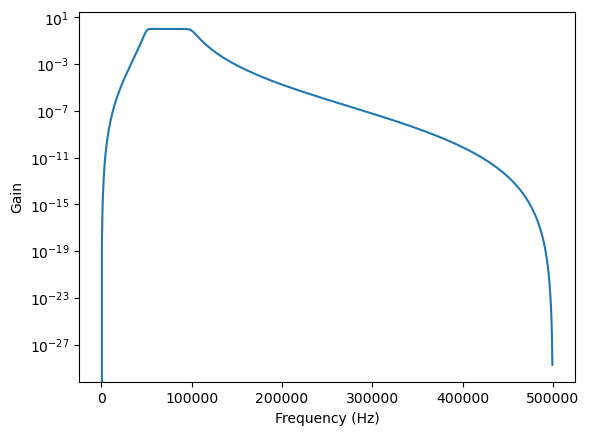

In [8]:
# use a log scale for the y-axis
plt.semilogy(frequencies, np.abs(filter_response))
plt.ylabel('Gain')
plt.xlabel('Frequency (Hz)')
plt.show()

**Exercise 2**

Part A:

Now it's time to try a filter out for yourself. Check out some of the filter options available in the scipy.signal documentation here:

https://docs.scipy.org/doc/scipy/reference/signal.html#matlab-style-iir-filter-design

Pick one of these and implement a bandpass filter to pass any frequency between 80 kHz and 120 kHz. Check out the frequency response of the filter and try adjusting the filter order to see what effect this has.

***Note: Some of these filters require extra inputs that we didn't use with the Butterworth filter, like ripple and attenuation. The function descriptions and examples describe these more. Be sure to pay attention to units (like decibels). The usage examples are a good way to get an initial guess for the value of ripple and attenuation to try.

Solution:

In [9]:
# Try it out here!
order = 8
cutoff_frequencies = [8e4, 12e4]

# define a filter with the new parameters
filter_sos_your_choice_here = signal.bessel(order, cutoff_frequencies, btype="bandpass", output="sos", fs=sample_frequency)

# evaluate filter response for a set of frequencies
frequencies, filter_response = signal.sosfreqz(filter_sos_your_choice_here, worN=1024, fs=sample_frequency)

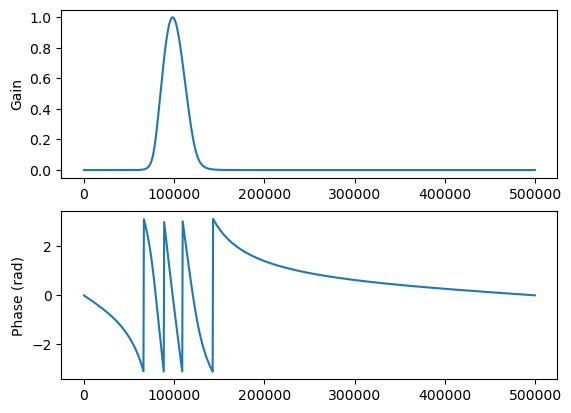

In [10]:
# plot filter gain and phase
plt.subplot(2,1,1)
plt.plot(frequencies, np.abs(filter_response))
plt.ylabel('Gain')
plt.subplot(2,1,2)
plt.plot(frequencies, np.angle(filter_response))
plt.ylabel('Phase (rad)')
plt.show()

Part B:

Now we're going to filter a signal with the filter from Part A! With the first rectangle filter example, we setup a filter in frequency space so that we could multiply the frequency representation of our signal. Here, we have a signal in time, and we are just going to pass the time series to a filter function that will do a lot of the work for us.

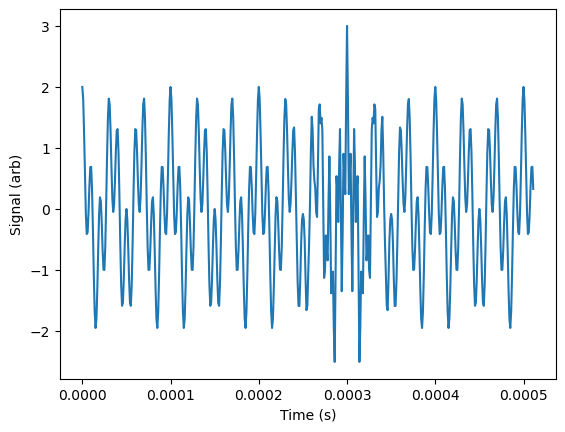

In [11]:
# define some frequencies for a signal
f1 = 3e4
f2 = 1e5
f3 = 2.5e5

# create time array
nsamples = 512
time = np.arange(nsamples)*dt

# two of the frequencies will have continuous amplitude, but the third will be pulsed
pulse_amplitude = np.exp(-((time - .0003)**2)/(1e-9) )

# add the frequency content together for our signal
signal_test = np.cos(2*np.pi*time*f1) + np.cos(2*np.pi*time*f2) + pulse_amplitude*np.cos(2*np.pi*time*f3)

# plot the new signal
plt.plot(time,signal_test)
plt.ylabel('Signal (arb)')
plt.xlabel('Time (s)')
plt.show()

Apply your filter to this signal using the function signal.sosfilt, after reading the documentation here:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfilt.html#scipy.signal.sosfilt

First use the filter you've already made to pass only the middle frequency at 100 kHz. Then, adjust your filter to pass only the high frequency component at 250 kHz. What do you observe in these signals?

Solution:

In [12]:
# Try it out here!
# first use sosfilt to apply your filter to signal_test
signal_filtered_100 = signal.sosfilt(filter_sos_your_choice_here, signal_test)

# next create a new filter for the high frequency component
# modify the cutoff frequencies
cutoff_frequencies = [200e3, 300e3]

# create a new Butterworth filter for the high frequency component
filter_sos_f3 = signal.butter(order, cutoff_frequencies, btype="bandpass", output="sos", fs=sample_frequency)

# filter signal_test with the new Butterworth filter, again using sosfilt
signal_filtered_250 = signal.sosfilt(filter_sos_f3, signal_test)

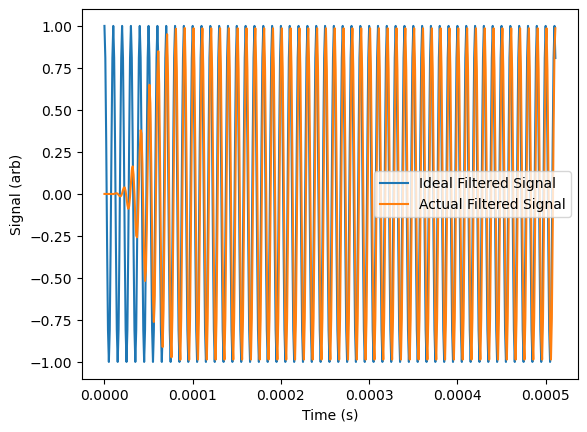

In [13]:
# create a time series with just the f2 component for comparison
signal_f2 = np.cos(2*np.pi*time*f2)

# plot the filtered signal and the original component
plt.plot(time, signal_f2, label='Ideal Filtered Signal')
plt.plot(time, signal_filtered_100, label='Actual Filtered Signal')
plt.ylabel('Signal (arb)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

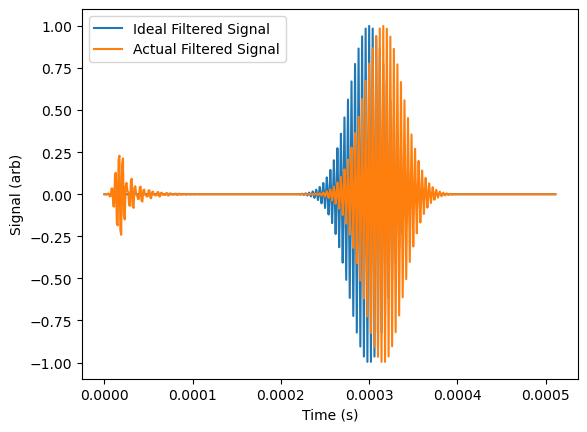

In [14]:
# isolate just the pulsed component from the original signal for comparison
signal_f3 = pulse_amplitude*np.cos(2*np.pi*time*f3)

# plot the filtered signal and the original component
plt.plot(time, signal_f3, label='Ideal Filtered Signal')
plt.plot(time, signal_filtered_250, label='Actual Filtered Signal')
plt.ylabel('Signal (arb)')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

Great, in each case we successfully selected only one of the frequencies! But what's up with the signal here? Notice how the filter doesn't start working right away for the middle frequency, and it takes a little time before the frequency we are interested in gets past the filter. Notice how the pulsed signal is also a little delayed compared to the original and has some strange oscillations near the very beginning.

1.   Filters can introduce time delay - the higher the order of the filter, the more delay
2.   Filters need a certain number of samples as input in order to work properly, so the very beginning and end of your filtered signal will often have undesirable artifacts

##Zero-phase filtering

The time delay problem we observed in the previous exercise can be resolved by using a technique called zero-phase filtering. This can be accomplished by applying a filter foward in time on a signal, and then applying the filter again except running it backward in time. The result is that the gain for the filter is squared, while the phase response goes to zero. Recall earlier that the filters we were applying had different phases at different frequencies - for a zero-phase filter this is not the case.

Note: This doesn't matter much for the exercises we are doing here, but zero-phase filtering can only be done when you have enough of your signal measured to be able to run a forward-backward filter. This isn't something you can do real-time.

Here's an example of forward-backward filtering using the filter from earlier with the signal.sosfiltfilt function instead of signal.sosfilt (we can call them the same way). Note how the delayed onset at the beginning is reduced (but now there is also a delay at the end).

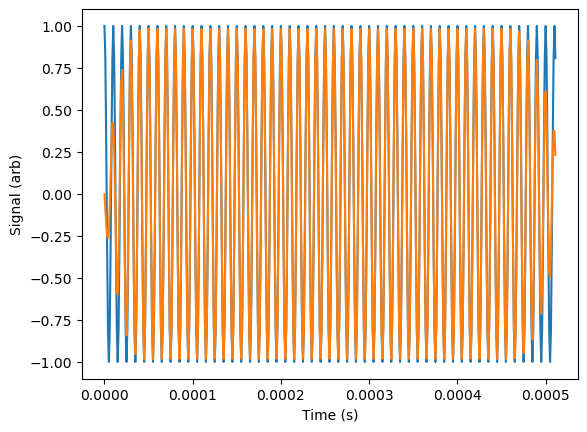

In [15]:
# filter the signal with the Bessel filter we used above but now using zero-phase filtering with sosfiltfilt
signal_filtered = signal.sosfiltfilt(filter_sos_your_choice_here, signal_test)

# plot the zero-phase filtered signal and the original component
plt.plot(time, signal_f2)
plt.plot(time, signal_filtered)
plt.ylabel('Signal (arb)')
plt.xlabel('Time (s)')
plt.show()

**Exercise 3**

Now try zero-phase filtering on the pulsed signal!

In [16]:
# Try it out here!
# filter the signal with the Butterworth filter from above using zero-phase filtering with sosfiltfilt
signal_filtered = signal.sosfiltfilt(filter_sos_your_choice_here, signal_test)

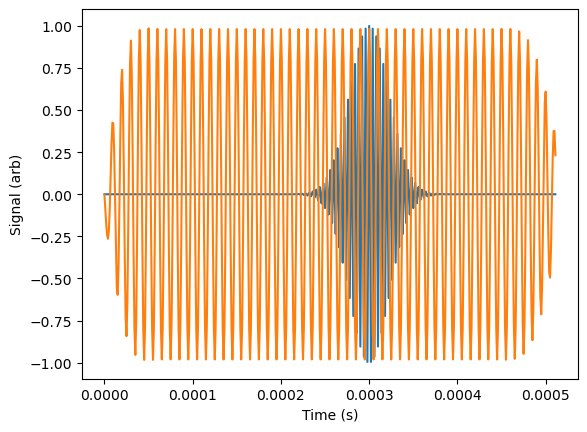

In [17]:
# plot the zero-phase filtered signal and the original component
plt.plot(time, signal_f3)
plt.plot(time, signal_filtered)
plt.ylabel('Signal (arb)')
plt.xlabel('Time (s)')
plt.show()